<a href="https://colab.research.google.com/github/alqarnsh/Bayesian-Semi-supervised-Impedance-Inversion/blob/main/Marmousi_Unet_TL_F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')
!pip install pylops

MessageError: Error: credential propagation was unsuccessful

# **1- DATA LOADING**

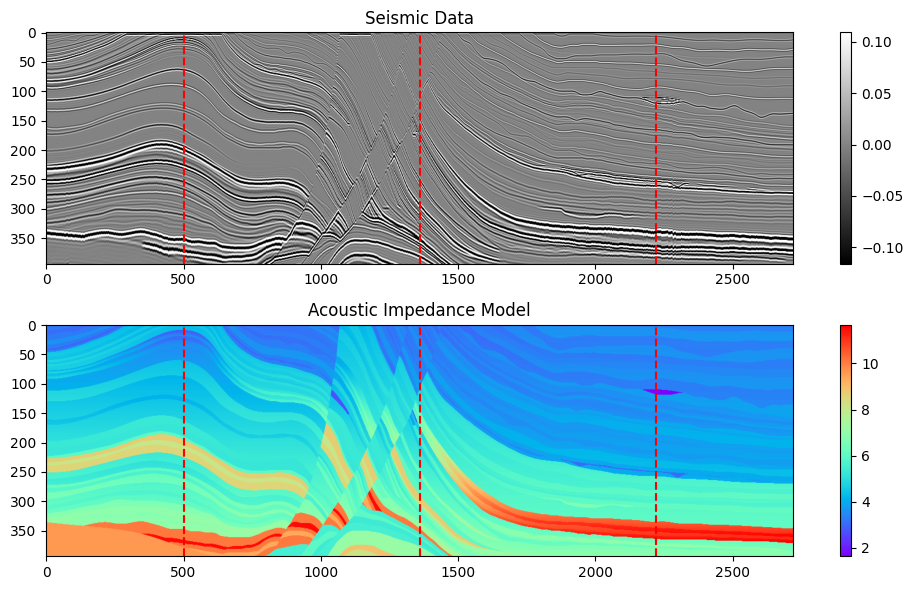

(array([ 500, 1360, 2221]), (394, 2721), (394, 2721))

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#-----------LoadData---------------------#
path= '/content/drive/MyDrive/Marmousi/marmousi_Ip_model.npy'
path1='/content/drive/MyDrive/Marmousi/marmousi_synthetic_seismic.npy'
seismic_data = np.load(path1).squeeze()
seismic_data = np.rot90(seismic_data, k=-1)
seismic_data=seismic_data[100:-207]
AI_data = np.load(path).squeeze()[::5, ::4]
AI_data = np.rot90(AI_data, k=-1)
AI_data =AI_data /1000
AI_data=AI_data[100:-207]
#-----------Gain-------------------------#
gain_factor = 0.1
vmin = np.min(seismic_data) * gain_factor
vmax = np.max(seismic_data) * gain_factor

#-----------NumberOfWells----------------#
indices = np.linspace(500, seismic_data.shape[1] - 500, 3, dtype=int)
#-----------Plotting---------------------#
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.imshow(seismic_data, aspect='auto', cmap='grey', vmin=vmin, vmax=vmax)
plt.title("Seismic Data")
plt.colorbar()
for idx in indices:
    plt.axvline(idx, color='red', linestyle='--', linewidth=1.5, label=f'Well at {idx}' if idx == indices[0] else None)

plt.subplot(2, 1, 2)
plt.imshow(AI_data, aspect='auto', cmap='rainbow')
plt.title("Acoustic Impedance Model")
plt.colorbar()
for idx in indices:
    plt.axvline(idx, color='red', linestyle='--', linewidth=1.5)

plt.tight_layout()
plt.show()

#-----------DataStats----------------#
indices , AI_data.shape, seismic_data.shape


In [3]:
#-----------ExtractPairsOfSeisTrac&IP---------#
selected_seismic_traces = seismic_data[:, indices]
selected_AI_traces_r = AI_data[:, indices]
#----------Normalizaing-----------------------#
def z_score_normalize(data):
    mean = np.mean(data)
    std = np.std(data)
    return (data - mean) / std
selected_seismic_traces=z_score_normalize(selected_seismic_traces)
seismic_data_normalized=z_score_normalize(seismic_data)
#-----------DataStats-------------------------#
selected_seismic_traces.shape, selected_AI_traces_r.shape

((394, 3), (394, 3))

# **2- WAVELET ESTIMATION**

/usr/local/lib/python3.11/dist-packages/pylops/utils/wavelets.py:21: UserWarning: one sample removed from time axis...
  warnings.warn("one sample removed from time axis...")
<ipython-input-6-c1c543aded89>:106: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


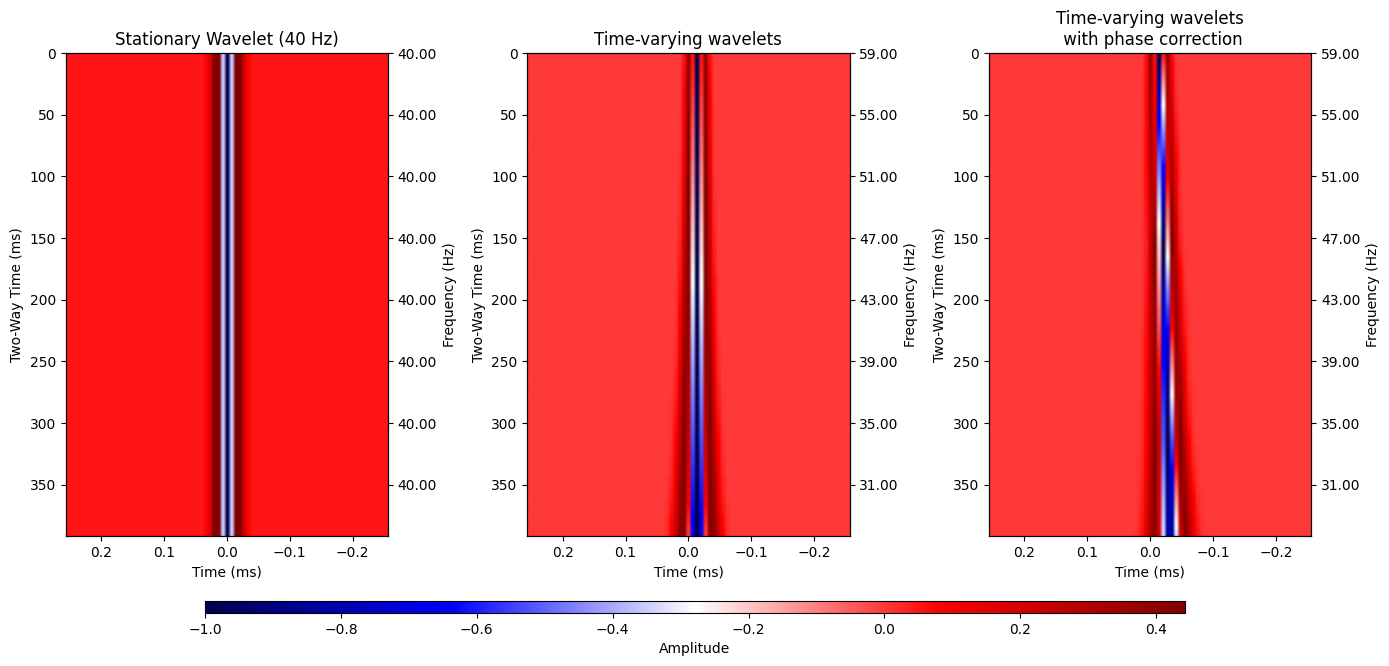

In [6]:
import numpy as np
from scipy.signal import filtfilt
import pylops
from pylops.utils.wavelets import ricker
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d


# Setup
nt = len(selected_AI_traces_r[:-2,0])     # NumberOfTimeSamples
dt = 0.004                              # SamplingInterval
ts = np.arange(nt) * dt                 # ConvertSamplingtoTime
Lp = np.log(selected_AI_traces_r[:-2, 0]) #lnOfIP

T = 0.256                               # Waveletdurationinseconds
ntwav = int(T / dt)                    # Numberofsamplesforwavelet

############################################
Fs = np.flip(np.arange(nt) * 0.08 + 28)  # Picking Starting Freq & Intervals to make Time-Varying Wavelets ⚠️ ⚠️ ⚠️
##########################################
##############################################
time_shifts = np.linspace(0, 0.01, len(Fs))#  # Small time shifts to the peaks ⚠️ ⚠️ ⚠️

# Function for fractional shift using interpolation
def wavelet_time_shift(wavelet, shift, dt):
    nt = len(wavelet)
    t = np.arange(nt) * dt
    t_shifted = t - shift
    interpolator = interp1d(t, wavelet, kind="linear", fill_value=0, bounds_error=False)
    return interpolator(t_shifted)




#-------------StatinorayCase----------------------------#
f_stationary = np.full(nt, 40)
wavs_stationary = -np.array([ricker(ts[:ntwav], f0)[0] for f0 in f_stationary])

#-------------Non-StatinorayCase-------------------------#
wavs_original = -np.array([ricker(ts[:ntwav], F)[0] for F in Fs])
shift_samples = int(0.01 / dt) #Making the wavelets starts after zero
wavs_original = np.roll(wavs_original, shift_samples)
#-------------Non-StatinorayCase_withPhaseCorr------------#
wavs_shifted = np.array([
    wavelet_time_shift(wav, shift, dt)
    for wav, shift in zip(wavs_original, time_shifts)
])
#----Equation ----> S=WDLp------------------------------#
WD_shifted = pylops.avo.poststack.PoststackLinearModelling(wavs_shifted / 2, nt0=nt, explicit=False)
WD = pylops.avo.poststack.PoststackLinearModelling(wavs_original / 2, nt0=nt, explicit=False)

#-------------Plot----------------------#1
fig, axs = plt.subplots(1, 3, figsize=(14, 6))

ax0 = axs[0]
img0 = ax0.imshow(wavs_stationary[:, 25:-25], cmap="seismic", extent=(ts[ntwav], -ts[ntwav], nt, 0))
ax0.set_title("Stationary Wavelet (40 Hz)")
ax0.set_ylabel("Two-Way Time (ms)")
ax0.set_xlabel("Time (ms)")
ax0.axis("tight")

freqs = np.flip(f_stationary)
tick_positions = np.arange(0, nt, 50)
ax0_right = ax0.twinx()
ax0_right.set_ylim(ax0.get_ylim())
ax0_right.set_yticks(tick_positions)
ax0_right.set_yticklabels([f"{freqs[int(pos)]:.2f}" for pos in tick_positions])
ax0_right.set_ylabel("Frequency (Hz)")
#--------------------------------------------#2

ax1 = axs[1]
img1 = ax1.imshow(wavs_original[:, 25:-25], cmap="seismic", extent=(ts[ntwav], -ts[ntwav], nt, 0))
ax1.set_title("Time-varying wavelets")
ax1.set_ylabel("Two-Way Time (ms)")
ax1.set_xlabel("Time (ms)")
ax1.axis("tight")

freqs = Fs
tick_positions = np.arange(0, nt, 50)
ax1_right = ax1.twinx()
ax1_right.set_ylim(ax1.get_ylim())
ax1_right.set_yticks(tick_positions)
ax1_right.set_yticklabels([f"{int(freqs[int(pos)]):.2f}" for pos in tick_positions])
ax1_right.set_ylabel("Frequency (Hz)")
#--------------------------------------------#3

ax2 = axs[2]
img2 = ax2.imshow(wavs_shifted[:, 25:-25], cmap="seismic", extent=(ts[ntwav], -ts[ntwav], nt, 0))
ax2.set_title("Time-varying wavelets\n with phase correction")
ax2.set_ylabel("Two-Way Time (ms)")
ax2.set_xlabel("Time (ms)")
ax2.axis("tight")


ax2_right = ax2.twinx()
ax2_right.set_ylim(ax2.get_ylim())
ax2_right.set_yticks(tick_positions)
ax2_right.set_yticklabels([f"{int(freqs[int(pos)]):.2f}" for pos in tick_positions])
ax2_right.set_ylabel("Frequency (Hz)")


#---------------colorbar----------------------#
cbar_ax = fig.add_axes([0.15, -0.03, 0.7, 0.02])
cbar = fig.colorbar(img2, cax=cbar_ax, orientation="horizontal")
cbar.set_label("Amplitude")
plt.tight_layout()
plt.show()



/usr/local/lib/python3.11/dist-packages/pylops/utils/wavelets.py:21: UserWarning: one sample removed from time axis...
  warnings.warn("one sample removed from time axis...")


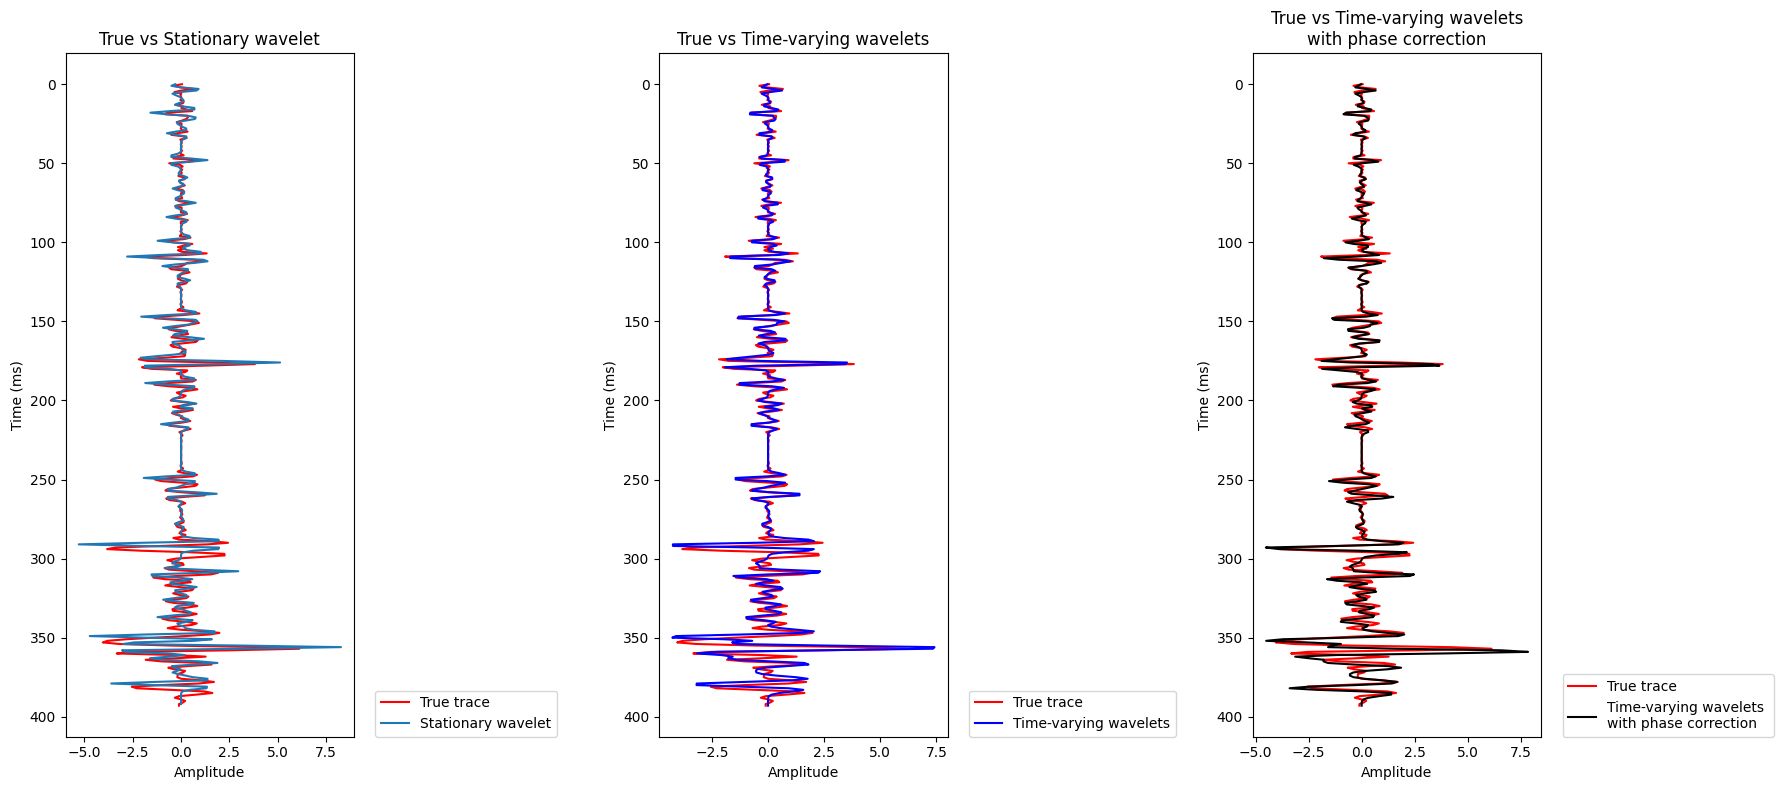

((393, 3), (394, 3))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from pylops.utils.wavelets import ricker

#----------RickerWavelet-------------------#
T = 0.256  # Wavelet duration
dt = 0.004  # Sampling interval
nnt = int(T / dt)  # Number of samples
t = np.arange(nnt) * dt  # Time
freq = 40  # Frequency in Hz
wavelet_40hz = ricker(t, freq)[0]
shift_samples = int(0.01 / dt)
wavelet_40hz = np.roll(wavelet_40hz, shift_samples)


#----------StatinorayCase-------------#
def calculate_reflectivity(impedance):
    reflectivity = (impedance[1:] - impedance[:-1]) / (impedance[1:] + impedance[:-1])
    return reflectivity
num_traces = selected_seismic_traces.shape[1]
synthetic_traces = []
for i in range(num_traces):
    ai_trace = selected_AI_traces_r[:, i]
    reflectivity = calculate_reflectivity(ai_trace)
    synthetic_trace = np.convolve(reflectivity, -wavelet_40hz, mode='same')
    synthetic_trace = z_score_normalize(synthetic_trace)
    synthetic_traces.append(synthetic_trace)


#-----------Non-StatinorayCase------------#
#------------ S=WDLp--------------------#
S_all = []
S_shifted_all = []
for i in range(num_traces):
    Lp = np.log(selected_AI_traces_r[:, i])  # ln Of AI for the current trace
     #-------------Non-StatinorayCase
    S = WD * Lp
    S=z_score_normalize(S)
    S_all.append(S)
    #-------------Non-StatinorayCase_withPhaseCorr
    S_shifted = WD_shifted * Lp
    S_shifted =z_score_normalize(S_shifted)
    S_shifted_all.append(S_shifted)



synthetic_traces = np.array(synthetic_traces).T
S_all = np.array(S_all).T
S_shifted_all = np.array(S_shifted_all).T
##################
trac_num = 1    # pick the trace # to visualize⚠️ ⚠️ ⚠️ ⚠️ ⚠️ ⚠️ ⚠️ ⚠️
################
S_1=S_all[:,trac_num]
S_shifted_1=S_shifted_all[:,trac_num]
synthetic_traces_1=synthetic_traces[:,trac_num]
selected_seismic_traces_1=selected_seismic_traces[:,trac_num]
#-------------Plot----------------------#1
fig, axs = plt.subplots(1, 3, figsize=(18, 8))
axs[0].plot(selected_seismic_traces_1, np.arange(len(selected_seismic_traces_1,)), label='True trace', color='r')
axs[0].plot(synthetic_traces_1, np.arange(len(synthetic_traces_1)), label="Stationary wavelet")
axs[0].set_xlabel('Amplitude')
axs[0].set_ylabel('Time (ms)')
axs[0].set_title('True vs Stationary wavelet')
axs[0].invert_yaxis()
axs[0].legend(loc="lower left", bbox_to_anchor=(1.05, -.01))

#-------------Plot----------------------#2

axs[1].plot(selected_seismic_traces_1, np.arange(len(selected_seismic_traces_1)), label='True trace', color='r')
axs[1].plot(S_1, np.arange(len(S_1)), label='Time-varying wavelets', color='blue')
axs[1].set_xlabel('Amplitude')
axs[1].set_ylabel('Time (ms)')
axs[1].set_title('True vs Time-varying wavelets')
axs[1].invert_yaxis()
axs[1].legend(loc="lower left", bbox_to_anchor=(1.05, -.01))

#-------------Plot----------------------#3
axs[2].plot(selected_seismic_traces_1, np.arange(len(selected_seismic_traces_1)), label='True trace', color='r')
axs[2].plot(S_shifted_1, np.arange(len(S_shifted_1)), label='Time-varying wavelets \nwith phase correction', color='k')
axs[2].set_xlabel('Amplitude')
axs[2].set_ylabel('Time (ms)')
axs[2].set_title('True vs Time-varying wavelets\nwith phase correction')
axs[2].invert_yaxis()
axs[2].legend(loc="lower left", bbox_to_anchor=(1.05, -.01))

plt.tight_layout()
plt.show()

#-----------DataStats-------------------------#
synthetic_traces.shape, selected_seismic_traces.shape


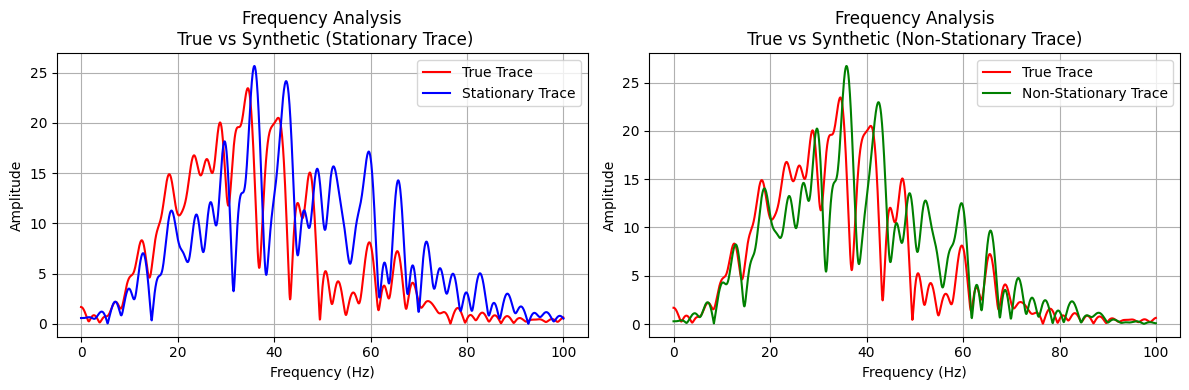

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, fftfreq

# Function to compute FFT with zero-padding
def compute_fft_zero_padded(signal, dt, pad_length):
    N = len(signal)
    X = np.zeros(pad_length)
    start_idx = (pad_length - N) // 2
    X[start_idx:start_idx + N] = signal
    fft_values = np.abs(fft(X))[:pad_length // 2]
    freqs = fftfreq(pad_length, dt)[:pad_length // 2]
    return freqs, fft_values

pad_length = 4096  # Zero-padding length for improved frequency resolution
start_time, end_time = 200, 300

# Extract the time window
synthetic_traces_windowed = synthetic_traces_1[start_time:end_time]
selected_seismic_traces_windowed = selected_seismic_traces_1[start_time:end_time]
S_1_windowed = S_1[start_time:end_time]
S_shifted_1_windowed = S_shifted_1[start_time:end_time]

# FFT
freqs, fft_synthetic = compute_fft_zero_padded(synthetic_traces_windowed, dt, pad_length)
_, fft_selected = compute_fft_zero_padded(selected_seismic_traces_windowed, dt, pad_length)
_, fft_S_1 = compute_fft_zero_padded(S_1_windowed, dt, pad_length)
_, fft_S_shifted_1 = compute_fft_zero_padded(S_shifted_1_windowed, dt, pad_length)
freq_mask = (freqs >= 0) & (freqs <= 100)
freqs_limited = freqs[freq_mask]
fft_synthetic_limited = fft_synthetic[freq_mask]
fft_selected_limited = fft_selected[freq_mask]
fft_S_1_limited = fft_S_1[freq_mask]
fft_S_shifted_1_limited = fft_S_shifted_1[freq_mask]

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(freqs_limited, fft_selected_limited, label="True Trace", color='r')
axs[0].plot(freqs_limited, fft_synthetic_limited, label="Stationary Trace", color='b')
axs[0].set_xlabel("Frequency (Hz)")
axs[0].set_ylabel("Amplitude")
axs[0].set_title("Frequency Analysis\n True vs Synthetic (Stationary Trace)")
axs[0].legend()
axs[0].grid()
axs[1].plot(freqs_limited, fft_selected_limited, label="True Trace", color='r')
axs[1].plot(freqs_limited, fft_S_1_limited, label="Non-Stationary Trace", color='g')
axs[1].set_xlabel("Frequency (Hz)")
axs[1].set_ylabel("Amplitude")
axs[1].set_title("Frequency Analysis\n True vs Synthetic (Non-Stationary Trace) ")
axs[1].legend()
axs[1].grid()



plt.tight_layout()
plt.show()


# **3- DATA AUGMENTATION**

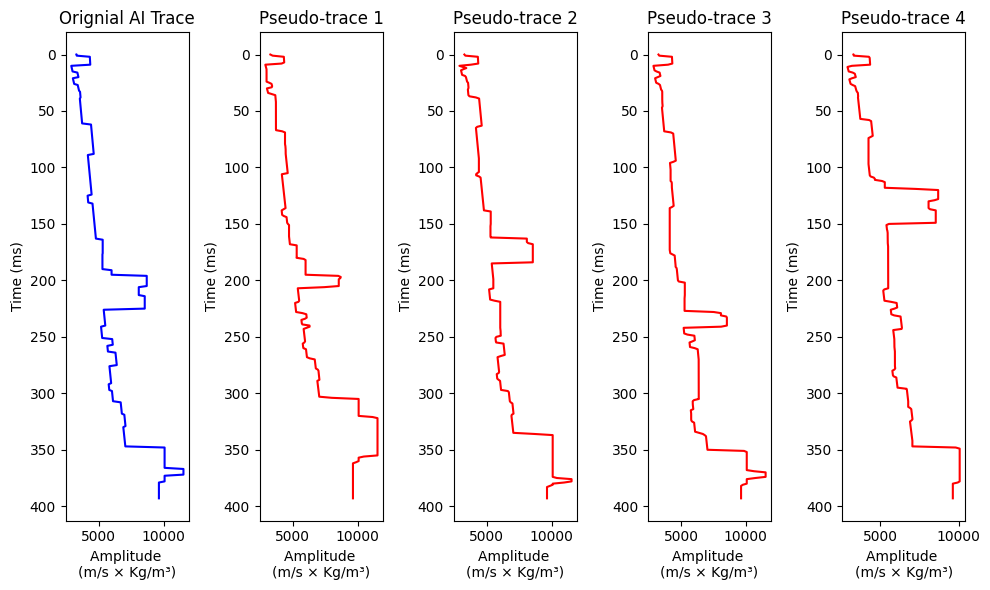

In [ ]:

#---------->>Augmentation Part 1 <<------------#
def stretch_squeeze_and_scale(series):
    num_points = 10
    series_copy = series.copy()
    #--------------------># Step 1: Stretch
    for _ in range(num_points):
        max_stretch = np.random.randint(20, 41)
        stretch_idx = np.random.randint(0, len(series_copy) - 1)
        stretch_amount = np.random.randint(1, max_stretch + 1)
        for _ in range(stretch_amount):
            series_copy = np.insert(series_copy, stretch_idx, series_copy[stretch_idx])

    #--------------------># Step 2: Squeeze
    for _ in range(num_points):
        max_stretch = np.random.randint(20, 41)
        squeeze_idx = np.random.randint(0, len(series_copy) - 1)
        squeeze_amount = np.random.randint(1, max_stretch + 1)
        series_copy = np.delete(series_copy, np.arange(squeeze_idx, min(squeeze_idx + squeeze_amount, len(series_copy))))
    #--------------------> Step 3: Interpolate back to original length
    series_copy = np.interp(np.linspace(0, len(series_copy) - 1, len(series)), np.arange(len(series_copy)), series_copy)

    return series_copy

#--------For visualazation only----------> 1 Trace
# pick one trace
trace_to_augment = selected_AI_traces_r[:, 0]*1000

# Generating 5 augmented traces examples to see the impact of agumetation parameters
augmented_traces = [stretch_squeeze_and_scale(trace_to_augment) for _ in range(4)]

#-------------Plot-----------------------------#
plt.figure(figsize=(10, 6))
plt.subplot(1, 5, 1)
plt.plot(trace_to_augment, np.arange(len(trace_to_augment)),  "blue")
plt.title("Orignial AI Trace")
plt.ylabel("Time (ms)")
plt.xlabel("Amplitude \n(m/s × Kg/m³)")
plt.gca().invert_yaxis()


for i, augmented_trace in enumerate(augmented_traces):
    plt.subplot(1, 5, i + 2)
    plt.plot(augmented_trace, np.arange(len(augmented_trace)),  "red")
    plt.title(f"Pseudo-trace {i+1}")
    plt.ylabel("Time (ms)")
    plt.xlabel("Amplitude \n(m/s × Kg/m³)")
    plt.gca().invert_yaxis()
plt.tight_layout()

#---------->>Augmentation Part 2 <<------------#
#----------->>Augment 3 Traces<<--------------#
traces_to_augment = selected_AI_traces_r[:, :]
num_augments_per_trace = 200
num_augments_total = traces_to_augment.shape[1] * num_augments_per_trace

# Generate and reshape augmented traces to a 2D shape (num_samples, num_augments_total)
augmented_traces = np.hstack([np.array([stretch_squeeze_and_scale(trace) for _ in range(num_augments_per_trace)]).T for trace in traces_to_augment.T])
#-------------- Shuffle the traces ------------#
augmented_traces = augmented_traces[:, np.random.permutation(augmented_traces.shape[1])]




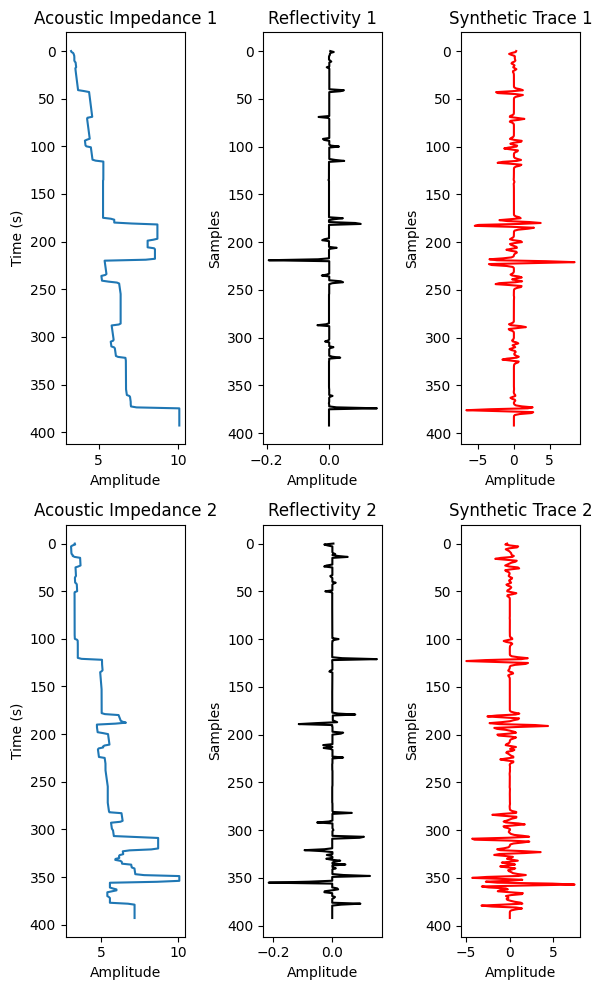

In [ ]:
#---------->>Creating Seismograms for each Ip trace <<------------#
#------------create data for two cases---------------------------#
#------------1-Stationary case----------------------------------#
#------------2-non-Stationary case-----------------------------#

from scipy.signal import convolve

#------Calc reflectivity-------------------------------------#
def calculate_reflectivity(acoustic_impedance):
    return np.diff(acoustic_impedance) / (acoustic_impedance[:-1] + acoustic_impedance[1:])
#------1-Stationary case------------------------------------#
def calculate_synthetic_trace(reflectivity, wavelet):
    return convolve(reflectivity, wavelet , mode='same')

selected_augmented_traces = augmented_traces[:, :]
all_reflectivities = []
synthetic_traces_statinoary = []
for i in range(selected_augmented_traces.shape[1]):
    ai = selected_augmented_traces[:, i]
    reflectivity = calculate_reflectivity(ai)
    synthetic_trace = calculate_synthetic_trace(reflectivity, -wavelet_40hz)
    all_reflectivities.append(reflectivity)
    synthetic_trace =z_score_normalize(synthetic_trace)
    synthetic_traces_statinoary.append(synthetic_trace)

all_reflectivities = np.array(all_reflectivities).T
synthetic_traces_statinoary = np.array(synthetic_traces_statinoary).T
time_axis = np.arange(selected_augmented_traces.shape[0])
plt.figure(figsize=(6, 10))
for i in range(2):
    ai = selected_augmented_traces[:, i]
    reflectivity = all_reflectivities[:, i]
    synthetic_trace = synthetic_traces_statinoary[:, i]
    plt.subplot(2, 3, i * 3 + 1)
    plt.plot(ai, time_axis)
    plt.title(f"Acoustic Impedance {i + 1}")
    plt.ylabel("Time (s)")
    plt.xlabel("Amplitude")
    plt.gca().invert_yaxis()

    plt.subplot(2, 3, i * 3 + 2)
    plt.plot(reflectivity, time_axis[:-1],"k")
    plt.title(f"Reflectivity {i + 1}")
    plt.xlabel("Amplitude")
    plt.ylabel("Samples")
    plt.gca().invert_yaxis()


    plt.subplot(2, 3, i * 3 + 3)
    plt.plot(synthetic_trace, time_axis[:-1],"r")
    plt.title(f"Synthetic Trace {i + 1}")
    plt.xlabel("Amplitude")
    plt.ylabel("Samples")
    plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()
#------------2-non-Stationary case-----------------------------#
n_traces = augmented_traces.shape[1]
synthetic_traces_non_stationary = np.zeros((nt, n_traces))
time_axis = np.arange(nt) * dt

for i in range(n_traces):
    ref = np.log(augmented_traces[:, i])
    synthetic_trace = WD_shifted * ref
    synthetic_trace =z_score_normalize(synthetic_trace)
    synthetic_traces_non_stationary[:, i] = synthetic_trace

time_axis = np.arange(selected_augmented_traces.shape[0])





In [ ]:
#------------------Save data-----------------------------#
import csv


synthetic_traces_statinoary_normalized = synthetic_traces_statinoary
synthetic_traces_non_stationary_normalized =synthetic_traces_non_stationary
with open('/content/drive/MyDrive/Marmousi/ai_traces_marmousi_nonstationary.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(augmented_traces)
with open('/content/drive/MyDrive/Marmousi/synthetic_traces_marmousi_nonstationary.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(synthetic_traces_non_stationary_normalized)
with open('/content/drive/MyDrive/Marmousi/synthetic_traces_marmousi_stationary.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(synthetic_traces_statinoary_normalized)



# **4- DATA SPLIT AND RESHAPING**

In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd

#---------------------Read Data-------------------------#
acoustic_impedance_path = '/content/drive/MyDrive/Marmousi/ai_traces_marmousi_nonstationary.csv'
synthetic_traces_path = '/content/drive/MyDrive/Marmousi/synthetic_traces_marmousi_nonstationary.csv'
# synthetic_traces_path = '/content/drive/MyDrive/Marmousi/synthetic_traces_marmousi_stationary.csv'
combined_augmented = pd.read_csv(acoustic_impedance_path, on_bad_lines='skip')
synthetic_traces = pd.read_csv(synthetic_traces_path, on_bad_lines='skip')


# synthetic_traces = synthetic_traces[:]
# combined_augmented = combined_augmented[:-1]

synthetic_traces = synthetic_traces[:-1]
combined_augmented = combined_augmented[:-1]

combined_augmented = combined_augmented.T.astype(float)
synthetic_traces = synthetic_traces.T.astype(float)

#--------------------- DATA Split (75-25) -----------------#
X_train, X_val, y_train, y_val = train_test_split(synthetic_traces, combined_augmented, test_size=0.25, random_state=42)

#----------------------- RESHAPING -----------------------#
X_train = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.values.reshape((X_val.shape[0], X_val.shape[1], 1))
y_train = y_train.values.reshape((y_train.shape[0], y_train.shape[1], 1))
y_val = y_val.values.reshape((y_val.shape[0], y_val.shape[1], 1))

#---------------- Data Stats --------------------------#
print("Shapes of Training and Validation sets:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_val:", X_val.shape)
print("y_val:", y_val.shape)


Shapes of Training and Validation sets:
X_train: (450, 392, 1)
y_train: (450, 392, 1)
X_val: (150, 392, 1)
y_val: (150, 392, 1)


# **5- 1D U-NET NETWORK TRAINING**

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 392, 1)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_15 (Conv1D)        │ (None, 392, 64)        │            256 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_16 (Conv1D)        │ (None, 392, 64)        │         12,352 │ conv1d_15[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_3           │ (None, 196, 64)        │              0 │ conv1d_16[0][0]        │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_17 (Conv1D)        │ (None, 196, 128)       │         41,088 │ max_pooling1d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_18 (Conv1D)        │ (None, 196, 128)       │         82,048 │ conv1d_17[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_4           │ (None, 98, 128)        │              0 │ conv1d_18[0][0]        │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_19 (Conv1D)        │ (None, 98, 256)        │        229,632 │ max_pooling1d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_20 (Conv1D)        │ (None, 98, 256)        │        459,008 │ conv1d_19[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_5           │ (None, 49, 256)        │              0 │ conv1d_20[0][0]        │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_21 (Conv1D)        │ (None, 49, 512)        │      1,180,160 │ max_pooling1d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_22 (Conv1D)        │ (None, 49, 512)        │      2,359,808 │ conv1d_21[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_transpose_3        │ (None, 98, 256)        │        262,400 │ conv1d_22[0][0]        │
│ (Conv1DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_3             │ (None, 98, 512)        │              0 │ conv1d_transpose_3[0]… │
│ (Concatenate)             │                        │                │ conv1d_20[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_23 (Conv1D)        │ (None, 98, 256)        │        917,760 │ concatenate_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_24 (Conv1D)        │ (None, 98, 256)        │        459,008 │ conv1d_23[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_transpose_4   

 Total params: 6,368,705 (24.29 MB)

 Trainable params: 6,368,705 (24.29 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 10/100 - Loss: 0.341691, Val Loss: 0.287917
Epoch 20/100 - Loss: 0.117629, Val Loss: 0.171852
Epoch 30/100 - Loss: 0.079261, Val Loss: 0.136636
Epoch 40/100 - Loss: 0.059537, Val Loss: 0.123941
Epoch 50/100 - Loss: 0.044646, Val Loss: 0.117485
Epoch 60/100 - Loss: 0.100751, Val Loss: 0.123112
Epoch 70/100 - Loss: 0.045255, Val Loss: 0.106543
Epoch 80/100 - Loss: 0.023078, Val Loss: 0.134011
Epoch 90/100 - Loss: 0.021224, Val Loss: 0.111132
Epoch 94: early stopping
Restoring model weights from the end of the best epoch: 84.
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 411ms/step - loss: 0.1118
Validation MSE: 0.10297438502311707


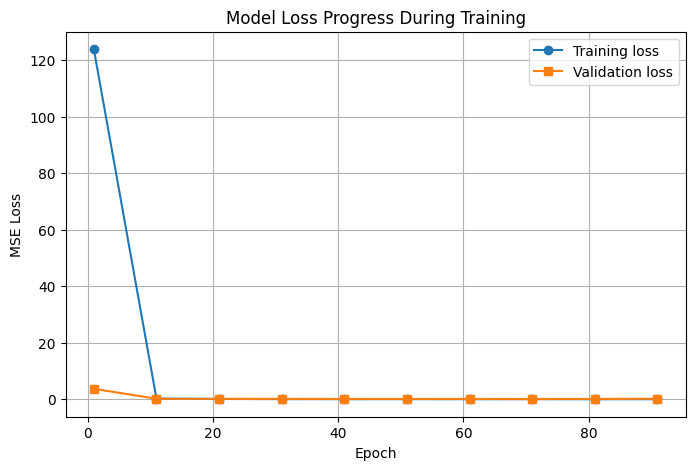

In [ ]:
from tensorflow.keras.layers import Conv1D, Conv1DTranspose, MaxPooling1D, concatenate, Input, Cropping1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, Callback
import matplotlib.pyplot as plt
import numpy as np

# Define the 1D U-Net model
def unet_1d(input_shape):
    inputs = Input(shape=input_shape)

    # Encoder
    c1 = Conv1D(64, 3, activation='relu', padding='same')(inputs)
    c1 = Conv1D(64, 3, activation='relu', padding='same')(c1)
    p1 = MaxPooling1D(2)(c1)

    c2 = Conv1D(128, 5, activation='relu', padding='same')(p1)
    c2 = Conv1D(128, 5, activation='relu', padding='same')(c2)
    p2 = MaxPooling1D(2)(c2)

    c3 = Conv1D(256, 7, activation='relu', padding='same')(p2)
    c3 = Conv1D(256, 7, activation='relu', padding='same')(c3)
    p3 = MaxPooling1D(2)(c3)

    # Bottleneck
    c4 = Conv1D(512, 9, activation='relu', padding='same')(p3)
    c4 = Conv1D(512, 9, activation='relu', padding='same')(c4)

    # Decoder
    u5 = Conv1DTranspose(256, 2, strides=2, padding='same')(c4)
    if u5.shape[1] != c3.shape[1]:
        c3 = Cropping1D((0, u5.shape[1] - c3.shape[1]))(c3)
    u5 = concatenate([u5, c3])
    c5 = Conv1D(256, 7, activation='relu', padding='same')(u5)
    c5 = Conv1D(256, 7, activation='relu', padding='same')(c5)

    u6 = Conv1DTranspose(128, 2, strides=2, padding='same')(c5)
    if u6.shape[1] != c2.shape[1]:
        c2 = Cropping1D((0, u6.shape[1] - c2.shape[1]))(c2)
    u6 = concatenate([u6, c2])
    c6 = Conv1D(128, 5, activation='relu', padding='same')(u6)
    c6 = Conv1D(128, 5, activation='relu', padding='same')(c6)

    u7 = Conv1DTranspose(64, 2, strides=2, padding='same')(c6)
    if u7.shape[1] != c1.shape[1]:
        c1 = Cropping1D((0, u7.shape[1] - c1.shape[1]))(c1)
    u7 = concatenate([u7, c1])
    c7 = Conv1D(64, 3, activation='relu', padding='same')(u7)
    c7 = Conv1D(64, 3, activation='relu', padding='same')(c7)

    # Output layer
    outputs = Conv1D(1, 1, activation='linear')(c7)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(), loss='mean_squared_error')
    return model

# Initialize model
unet_model = unet_1d((392, 1))
unet_model.summary()

# Custom callback to print loss every 10 epochs
class PrintEveryNEpoch(Callback):
    def __init__(self, N=10):
        super().__init__()
        self.N = N  # Interval for printing

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.N == 0:  # Print every 10 epochs
            print(f"Epoch {epoch+1}/{self.params['epochs']} - Loss: {logs['loss']:.6f}, Val Loss: {logs['val_loss']:.6f}")

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

# Model Training
history = unet_model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=10,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, PrintEveryNEpoch(10)],  # Print every 10 epochs
    verbose=0  # Suppress default output
)

# Model Evaluation
val_loss = unet_model.evaluate(X_val, y_val)
print('Validation MSE:', val_loss)

# Extract loss values
loss_values = history.history['loss']
val_loss_values = history.history['val_loss']

# Get epochs, showing every 10th epoch
epochs = np.arange(1, len(loss_values) + 1)
plot_epochs = epochs[::10]
plot_loss_values = loss_values[::10]
plot_val_loss_values = val_loss_values[::10]

# Plot Training and Validation Loss every 10 epochs
plt.figure(figsize=(8, 5))
plt.plot(plot_epochs, plot_loss_values, label='Training loss', marker='o', linestyle='-')
plt.plot(plot_epochs, plot_val_loss_values, label='Validation loss', marker='s', linestyle='-')
plt.title('Model Loss Progress During Training')
plt.ylabel('MSE Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid()
plt.show()


# **6- NETWORK EVALUATION**


86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step


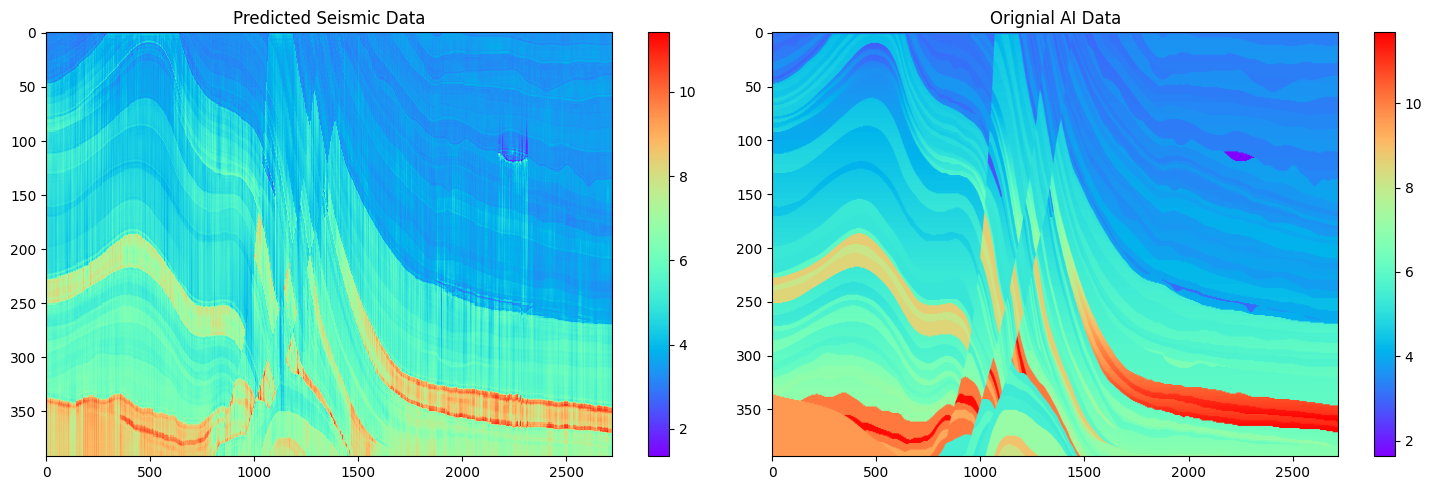

Average R² Score across all traces: 0.8443
Average PCC across all traces: 0.9552


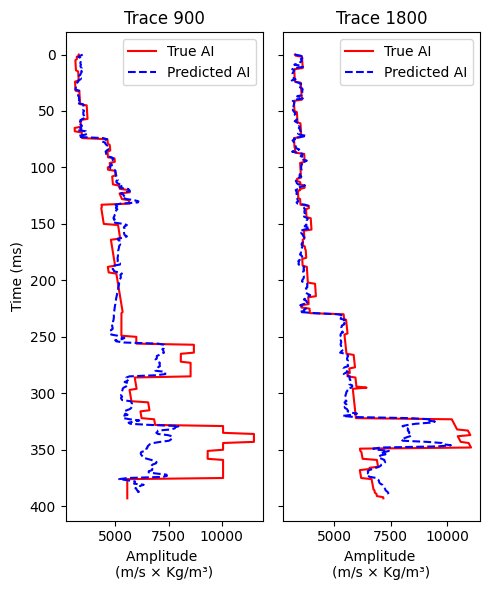

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
import numpy as np

seismic_data_normalized_reshaped = np.expand_dims(seismic_data_normalized[:-2].T, axis=-1)
ai_predictions = unet_model.predict(seismic_data_normalized_reshaped)

ai_predictions_section = ai_predictions.squeeze()
ai_predictions_section = ai_predictions_section.T
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.imshow(ai_predictions_section, aspect='auto', cmap='rainbow', interpolation='none')
plt.title("Predicted Seismic Data")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(AI_data, aspect='auto', cmap='rainbow')
plt.title("Orignial AI Data")
plt.colorbar()

plt.tight_layout()
plt.show()

num_traces = AI_data[:-2].shape[1]  # Number of traces
r2_scores = []
pcc_scores = []

for i in range(num_traces):
    # Calculate R²
    r2 = r2_score(AI_data[:-2, i], ai_predictions_section[:, i])
    r2_scores.append(r2)

    # Calculate PCC
    pcc, _ = pearsonr(AI_data[:-2, i], ai_predictions_section[:, i])
    pcc_scores.append(pcc)

r2_scores = np.array(r2_scores)
pcc_scores = np.array(pcc_scores)

# Average R² and PCC scores across all traces
average_r2 = np.mean(r2_scores)
average_pcc = np.mean(pcc_scores)

print(f'Average R² Score across all traces: {average_r2:.4f}')
print(f'Average PCC across all traces: {average_pcc:.4f}')

fig, axs = plt.subplots(1, 2, figsize=(5, 6), sharey=True)

# Plot for trace 900
axs[0].plot(AI_data[:, 900]*1000, np.arange(len(AI_data[:, 900])), label="True AI", color="red")
axs[0].plot(ai_predictions_section[:, 900]*1000, np.arange(len(ai_predictions_section[:, 900])), label="Predicted AI", linestyle="dashed", color="blue")
axs[0].set_xlabel("Amplitude \n(m/s × Kg/m³)")
axs[0].set_ylabel("Time (ms)")
axs[0].set_title("Trace 900")
axs[0].invert_yaxis()
axs[0].legend()

# Plot for trace 1800
axs[1].plot(AI_data[:, 1800]*1000, np.arange(len(AI_data[:, 1800])), label="True AI", color="red")
axs[1].plot(ai_predictions_section[:, 1800]*1000, np.arange(len(ai_predictions_section[:, 1800])), label="Predicted AI", linestyle="dashed", color="blue")
axs[1].set_xlabel("Amplitude \n(m/s × Kg/m³)")
axs[1].set_title("Trace 1800")
# axs[1].invert_yaxis()
axs[1].legend()

plt.tight_layout()
plt.show()


# **7- FINE-TUNING WITH TRANSFER LEARNING**


In [ ]:
import numpy as np
import pandas as pd

combined_augmented = selected_AI_traces_r[:-2, :]
synthetic_traces = selected_seismic_traces[:-2, :]
combined_augmented = combined_augmented.T.astype(float)
synthetic_traces = synthetic_traces.T.astype(float)

X_train = synthetic_traces
y_train = combined_augmented


X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], 1))


print("Shapes of Training set:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)


Shapes of Training set:
X_train: (3, 392, 1)
y_train: (3, 392, 1)


Epoch 10/150 - Loss: 0.598567
Epoch 20/150 - Loss: 0.350348
Epoch 30/150 - Loss: 0.203365
Epoch 40/150 - Loss: 0.125495
Epoch 49: early stopping
Restoring model weights from the end of the best epoch: 39.


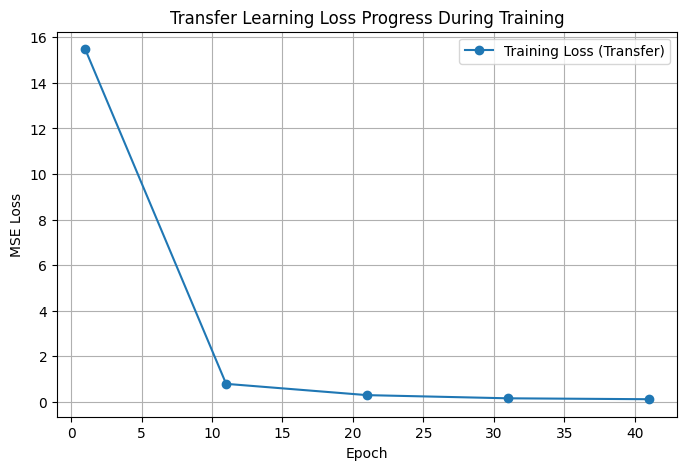

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

unet_model_transfer = unet_1d((392, 1))
unet_model_transfer.set_weights(unet_model.get_weights())

for layer in unet_model_transfer.layers[:14]:
    layer.trainable = False


unet_model_transfer.compile(optimizer=Adam(learning_rate=1e-3), loss='mean_squared_error')


class PrintEveryNEpoch(Callback):
    def __init__(self, N=10):
        super().__init__()
        self.N = N

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.N == 0:
            print(f"Epoch {epoch+1}/{self.params['epochs']} - Loss: {logs['loss']:.6f}")

early_stopping = EarlyStopping(
    monitor='loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)


history_transfer = unet_model_transfer.fit(
    X_train,
    y_train,
    epochs=150,
    batch_size=1,
    callbacks=[early_stopping, PrintEveryNEpoch(10)],
    verbose=0
)


loss_values = history_transfer.history['loss']

epochs = np.arange(1, len(loss_values) + 1)
plot_epochs = epochs[::10]
plot_loss_values = loss_values[::10]

plt.figure(figsize=(8, 5))
plt.plot(plot_epochs, plot_loss_values, label='Training Loss (Transfer)', marker='o', linestyle='-')
plt.title('Transfer Learning Loss Progress During Training')
plt.ylabel('MSE Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid()
plt.show()


86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step


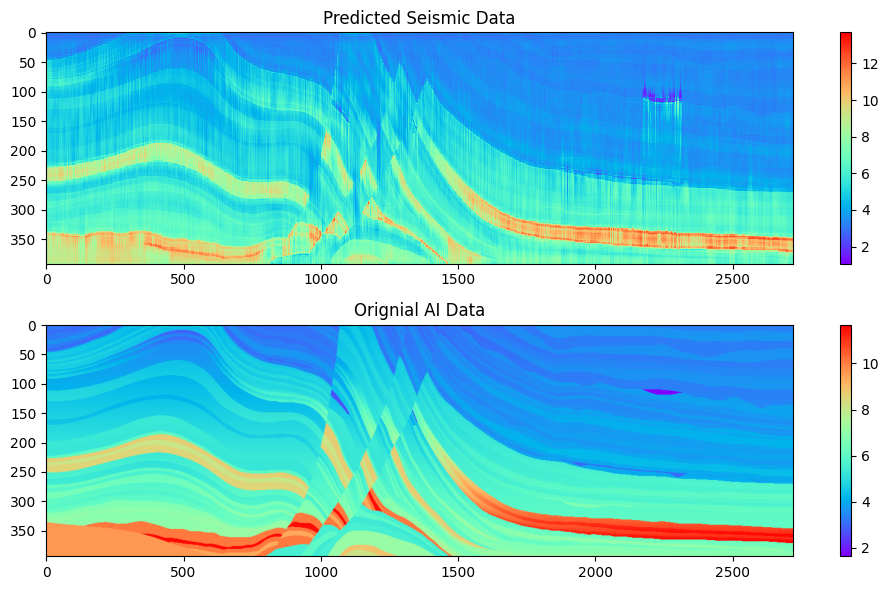

Average R² Score across all traces: 0.9051
Average PCC across all traces: 0.9630


In [ ]:
import numpy as np
from sklearn.metrics import r2_score

seismic_data_normalized_reshaped = np.expand_dims(seismic_data_normalized[:-2].T, axis=-1)
ai_predictions_1 = unet_model_transfer.predict(seismic_data_normalized_reshaped)
ai_predictions_section_1 = ai_predictions_1.squeeze()

ai_predictions_section_1 =ai_predictions_section_1.T
plt.figure(figsize=(10, 6))


plt.subplot(2, 1, 1)
plt.imshow(ai_predictions_section_1, aspect='auto', cmap='rainbow', interpolation='none')
plt.title("Predicted Seismic Data")
plt.colorbar()

plt.subplot(2, 1, 2)
plt.imshow(AI_data, aspect='auto', cmap='rainbow')
plt.title("Orignial AI Data")
plt.colorbar()
plt.tight_layout()
plt.show()



ai_predictions_flat = ai_predictions_section_1.flatten()
AI_data_flat = AI_data[:-2,:].flatten()


num_traces = AI_data[:-2].shape[1]
r2_scores = []
pcc_scores = []

for i in range(num_traces):
    # Calculate R²
    r2 = r2_score(AI_data[:-2, i], ai_predictions_section_1[:, i])
    r2_scores.append(r2)

    # Calculate PCC
    pcc, _ = pearsonr(AI_data[:-2, i], ai_predictions_section_1[:, i])
    pcc_scores.append(pcc)

r2_scores = np.array(r2_scores)
pcc_scores = np.array(pcc_scores)
average_r2 = np.mean(r2_scores)
average_pcc = np.mean(pcc_scores)

print(f'Average R² Score across all traces: {average_r2:.4f}')
print(f'Average PCC across all traces: {average_pcc:.4f}')



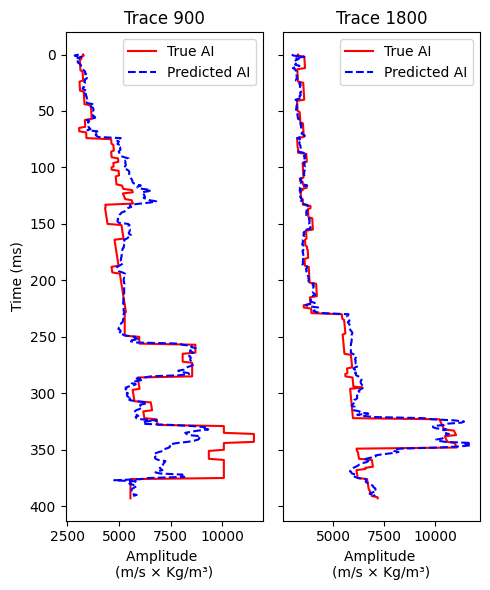

In [ ]:

fig, axs = plt.subplots(1, 2, figsize=(5, 6), sharey=True)

axs[0].plot(AI_data[:, 900]*1000, np.arange(len(AI_data[:, 900])), label="True AI", color="red")
axs[0].plot(ai_predictions_section_1[:, 900]*1000, np.arange(len(ai_predictions_section[:, 900])), label="Predicted AI", linestyle="dashed", color="blue")
axs[0].set_xlabel("Amplitude \n(m/s × Kg/m³)")
axs[0].set_ylabel("Time (ms)")
axs[0].set_title("Trace 900")
axs[0].invert_yaxis()
axs[0].legend()

# Plot for trace 1800
axs[1].plot(AI_data[:, 1800]*1000, np.arange(len(AI_data[:, 1800])), label="True AI", color="red")
axs[1].plot(ai_predictions_section_1[:, 1800]*1000, np.arange(len(ai_predictions_section[:, 1800])), label="Predicted AI", linestyle="dashed", color="blue")
axs[1].set_xlabel("Amplitude \n(m/s × Kg/m³)")
axs[1].set_title("Trace 1800")
axs[1].legend()

plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


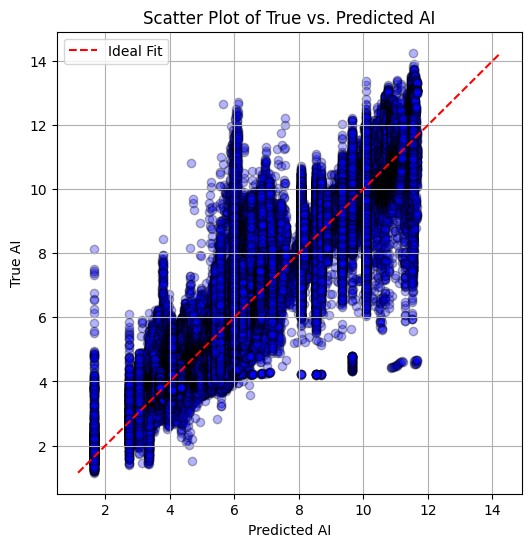

In [ ]:
import matplotlib.pyplot as plt

# Scatter plot of true vs estimated AI
plt.figure(figsize=(6, 6))
plt.scatter(AI_data_flat, ai_predictions_flat, alpha=0.3, color="blue", edgecolors="k")
plt.xlabel("Predicted AI")
plt.ylabel("True AI")
plt.title("Scatter Plot of True vs. Predicted AI")
plt.grid(True)

min_val = min(ai_predictions_flat.min(), AI_data_flat.min())
max_val = max( ai_predictions_flat.max(), AI_data_flat.max())
plt.plot([min_val, max_val], [min_val, max_val], linestyle="--", color="red", label="Ideal Fit")

plt.legend()
plt.show()


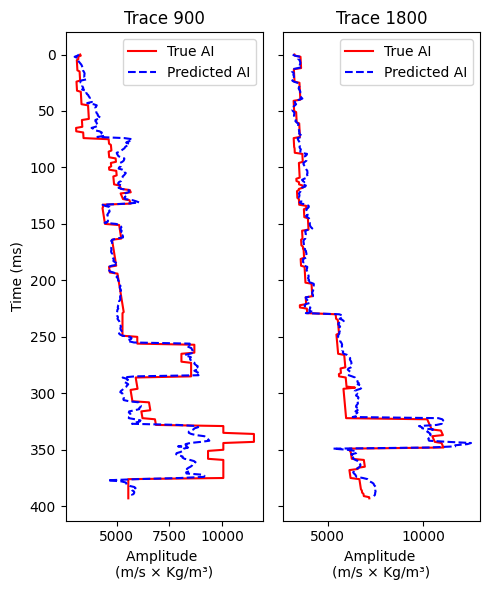

In [ ]:



fig, axs = plt.subplots(1, 2, figsize=(5, 6), sharey=True)

axs[0].plot(AI_data[:, 900]*1000, np.arange(len(AI_data[:, 900])), label="True AI", color="red")
axs[0].plot(ai_predictions_section_1[:, 900]*1000, np.arange(len(ai_predictions_section[:, 900])), label="Predicted AI", linestyle="dashed", color="blue")
axs[0].set_xlabel("Amplitude \n(m/s × Kg/m³)")
axs[0].set_ylabel("Time (ms)")
axs[0].set_title("Trace 900")
axs[0].invert_yaxis()
axs[0].legend()

# Plot for trace 1800
axs[1].plot(AI_data[:, 1800]*1000, np.arange(len(AI_data[:, 1800])), label="True AI", color="red")
axs[1].plot(ai_predictions_section_1[:, 1800]*1000, np.arange(len(ai_predictions_section[:, 1800])), label="Predicted AI", linestyle="dashed", color="blue")
axs[1].set_xlabel("Amplitude \n(m/s × Kg/m³)")
axs[1].set_title("Trace 1800")
axs[1].legend()

plt.tight_layout()
plt.show()



TypeError: Image data of dtype object cannot be converted to float

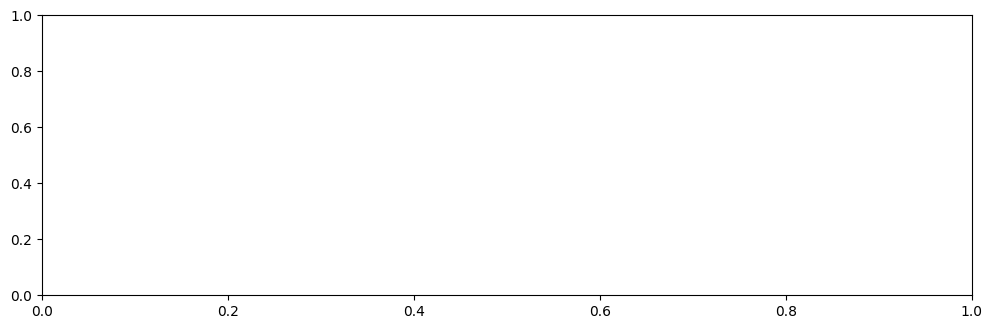

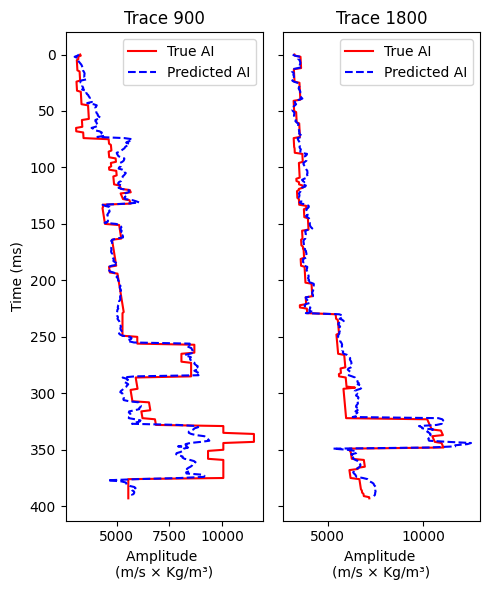

In [ ]:

fig, axs = plt.subplots(1, 2, figsize=(5, 6), sharey=True)

axs[0].plot(AI_data[:, 900]*1000, np.arange(len(AI_data[:, 900])), label="True AI", color="red")
axs[0].plot(ai_predictions_section_1[:, 900]*1000, np.arange(len(ai_predictions_section[:, 900])), label="Predicted AI", linestyle="dashed", color="blue")
axs[0].set_xlabel("Amplitude \n(m/s × Kg/m³)")
axs[0].set_ylabel("Time (ms)")
axs[0].set_title("Trace 900")
axs[0].invert_yaxis()
axs[0].legend()

# Plot for trace 1800
axs[1].plot(AI_data[:, 1800]*1000, np.arange(len(AI_data[:, 1800])), label="True AI", color="red")
axs[1].plot(ai_predictions_section_1[:, 1800]*1000, np.arange(len(ai_predictions_section[:, 1800])), label="Predicted AI", linestyle="dashed", color="blue")
axs[1].set_xlabel("Amplitude \n(m/s × Kg/m³)")
axs[1].set_title("Trace 1800")
axs[1].legend()

plt.tight_layout()
plt.show()




